In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM
import matplotlib.pyplot as plt
seed = 7
np.random.seed(seed)

In [2]:
data = pd.read_csv("YMCA.csv", index_col=0)

In [3]:
data.head()

,Month,Time,Hour,SolarRad,WindSpeed,THWIndex,InEMC,InAirDensity,Substation_VA_Filtered
Date,,,,,,,,,
2014-01-07,1,14:30:00,14,32,5,9.7,9.39,0.0739,249.059
2014-01-07,1,15:00:00,15,20,6,9.5,9.39,0.0740,248.710
2014-01-07,1,15:30:00,15,22,6,9.5,9.39,0.0740,247.321
2014-01-07,1,16:00:00,16,8,5,9.4,9.39,0.0741,247.267
2014-01-07,1,16:30:00,16,0,5,9.3,9.40,0.0742,247.255


In [7]:
# data = data.drop("OpenInt",axis=1)
data = data.drop(['Month', 'Time', 'Hour', 'THWIndex', 'InEMC', 'InAirDensity', 'Substation_VA_Filtered'], axis=1)
data.columns = ['SolarRad', 'WindSpeed']
data.index.name = 'Date'

data.fillna(0, inplace=True)
# drop the first 24 hours

data.to_csv("YMCA_clean.csv")

In [8]:
data.head()

,SolarRad,WindSpeed
Date,,
2014-01-07,32,5
2014-01-07,20,6
2014-01-07,22,6
2014-01-07,8,5
2014-01-07,0,5


In [23]:
data.shape

(15697, 2)

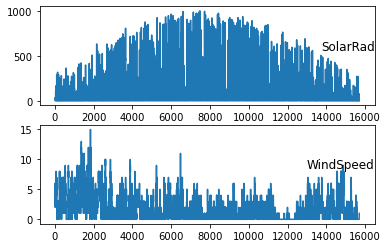

In [9]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('YMCA_clean.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [13]:
values = data.values
values

array([[32,  5],
       [20,  6],
       [22,  6],
       ...,
       [ 0,  1],
       [ 0,  1],
       [ 0,  1]], dtype=int64)

In [14]:
#Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
scaled

array([[0.03187251, 0.33333333],
       [0.01992032, 0.4       ],
       [0.02191235, 0.4       ],
       ...,
       [0.        , 0.06666667],
       [0.        , 0.06666667],
       [0.        , 0.06666667]])

In [15]:
#convert data to supervised form

def to_supervised(data,dropNa = True,lag = 1):
    df = pd.DataFrame(data)
    column = []
    column.append(df)
    for i in range(1,lag+1):
        column.append(df.shift(-i))
    df = pd.concat(column,axis=1)
    df.dropna(inplace = True)
    features = data.shape[1]
    df = df.values
    supervised_data = df[:,:features*lag]
    supervised_data = np.column_stack( [supervised_data, df[:,features*lag]])
    return supervised_data

In [48]:
timeSteps = 1

supervised = to_supervised(scaled,lag=timeSteps)
pd.DataFrame(supervised).head()
supervised.shape

(15696, 3)

In [54]:
X_train = []
y_train = []

for i in range(480, supervised.shape[0]):
    X_train.append(supervised[i-480:i,0:2])
    y_train.append(supervised[i, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)
x_train.shape,y_train.shape

((14128, 1, 2), (15216,))

In [34]:
data.shape[1]

2

In [41]:
# spiltting the data
# training on only first year data
features = data.shape[1]
train_hours = 14128
X = supervised[:,:features*timeSteps]
y = supervised[:,features*timeSteps]
X.shape
x_train = X[:train_hours,:]
x_test = X[train_hours:,:]
y_train = y[:train_hours]
y_test = y[train_hours:]

print (x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(14128, 2) (1568, 2) (14128,) (1568,)


In [ ]:
((11482, 480, 2))

In [42]:
#convert data to fit for lstm
#dimensions = (sample, timeSteps here it is 1, features )

x_train = x_train.reshape(x_train.shape[0], timeSteps, features)
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)

x_train.shape

(14128, 1, 2)

In [ ]:
#define the model

model = Sequential()
model.add( LSTM( 50, input_shape = ( timeSteps,x_train.shape[2]) ) )
model.add( Dense(1) )

model.compile( loss = "mae", optimizer = "adam")

history =  model.fit( x_train,y_train, validation_data = (x_test,y_test), epochs = 10 , batch_size = 10, verbose = 1, shuffle = False)

In [18]:
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)
x_test.shape

(934, 1, 7)

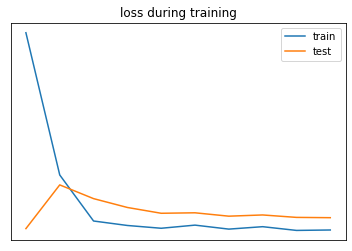

In [19]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.yticks([])
plt.xticks([])
plt.title("loss during training")
plt.show()

In [27]:
x_test = x_test.reshape(x_test.shape[0], timeSteps, features)
x_test.shape

(934, 1, 7)

In [28]:

#scale back the prediction to orginal scale
y_pred = model.predict(x_test)
print(y_pred.shape)
# x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2]) (for multiple timestep)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[2])
print(x_test.shape)

# Invert scaling for forecast
inv_new = np.concatenate( (y_pred, x_test[:,-6:] ) , axis =1) 
print(inv_new.shape)
inv_new = scaler.inverse_transform(inv_new)
print(inv_new.shape)
final_pred = inv_new[:,0]
# Invert scaling for actual
y_test = y_test.reshape( len(y_test), 1)

inv_new = np.concatenate( (y_test, x_test[:,-6:] ) ,axis = 1)
inv_new = scaler.inverse_transform(inv_new)
actual_pred = inv_new[:,0]

(934, 1)
(934, 7)
(934, 7)
(934, 7)


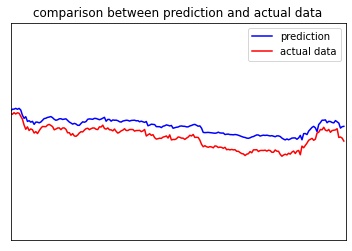

In [29]:
#plot the prediction with actual data

plt.plot(final_pred[:200], label = "prediction",c = "b")
plt.plot(actual_pred[:200],label = "actual data",c="r")
plt.xlim(0, 200)
plt.ylim(0, 300)
plt.yticks([])
plt.xticks([])
plt.title("comparison between prediction and actual data")
plt.legend()

In [30]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(actual_pred, final_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 15.981
